# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

11.0.0


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [ ]:
!ls train

simpsons_dataset


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 27 10:18:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import os
import pickle
from torchvision import transforms

# Константы
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224  # размер изображений для скалирования
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # работаем на GPU или CPU

class SimpsonDataset(Dataset):
    def __init__(self, files, y, mode='train'):
        self.data = files
        self.target = y
        self.len_ = len(files)
        self.mode = mode

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        if self.mode != 'train':
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            img = self.transform(self._prepare_example(self.data[index]))
            return img, self.target[index]

        else:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(0.3),
                transforms.RandomVerticalFlip(0.3),
                transforms.RandomRotation(20),
                transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 3)),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])

            img = self.transform(self._prepare_example(self.data[index]))
            return img, self.target[index]

    def _prepare_example(self, img):
        img = Image.open(img)
        img = img.resize((224, 224))
        img = np.array(img, dtype=np.float32) / 255.0
        return img


In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [ ]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

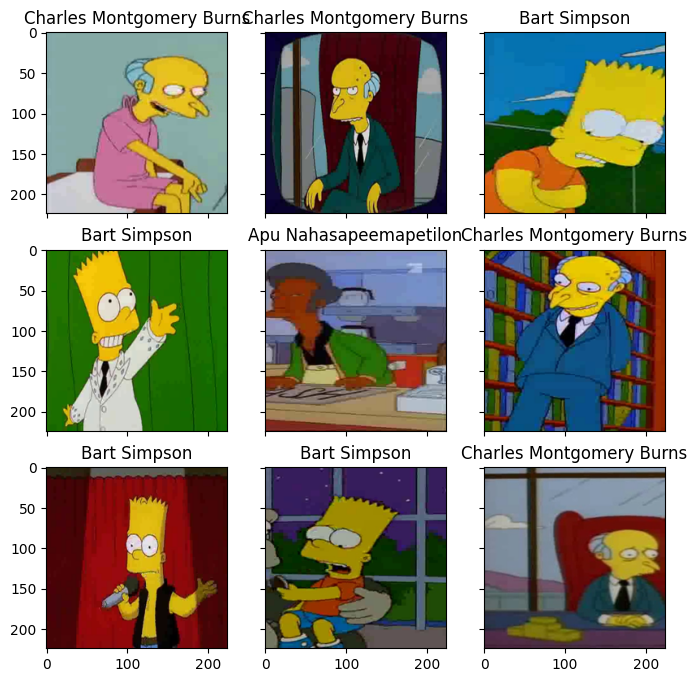

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [ ]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))

    return history

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 2.438265610913637


epoch:  50%|█████     | 1/2 [03:16<03:16, 196.28s/it]


Epoch 001 train_loss: 2.4383     val_loss 1.8306 train_acc 0.3249 val_acc 0.4998
loss 1.4511002259304875


epoch: 100%|██████████| 2/2 [05:44<00:00, 172.09s/it]


Epoch 002 train_loss: 1.4511     val_loss 1.2566 train_acc 0.6027 val_acc 0.6639


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

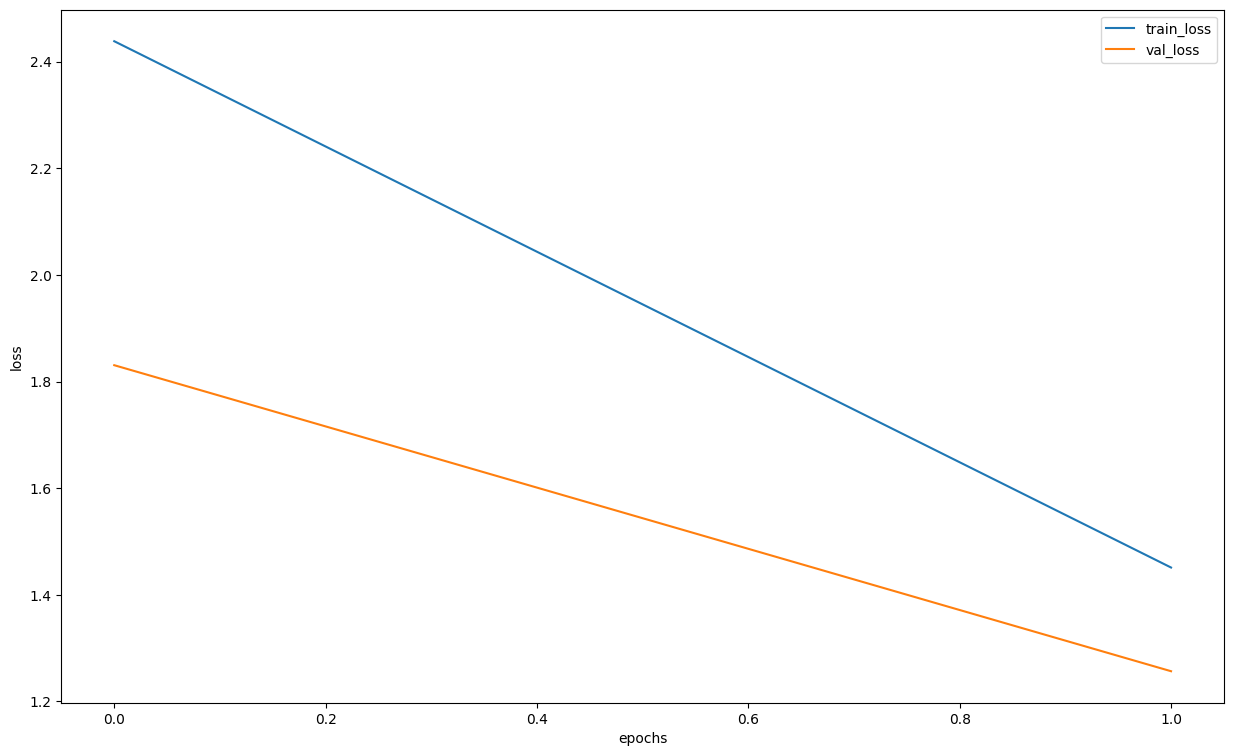

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
from sklearn.metrics import f1_score
f1 = f1_score(actual_labels, y_pred, average='micro')

print("F1-оценка:", f1)


F1-оценка: 0.5


Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

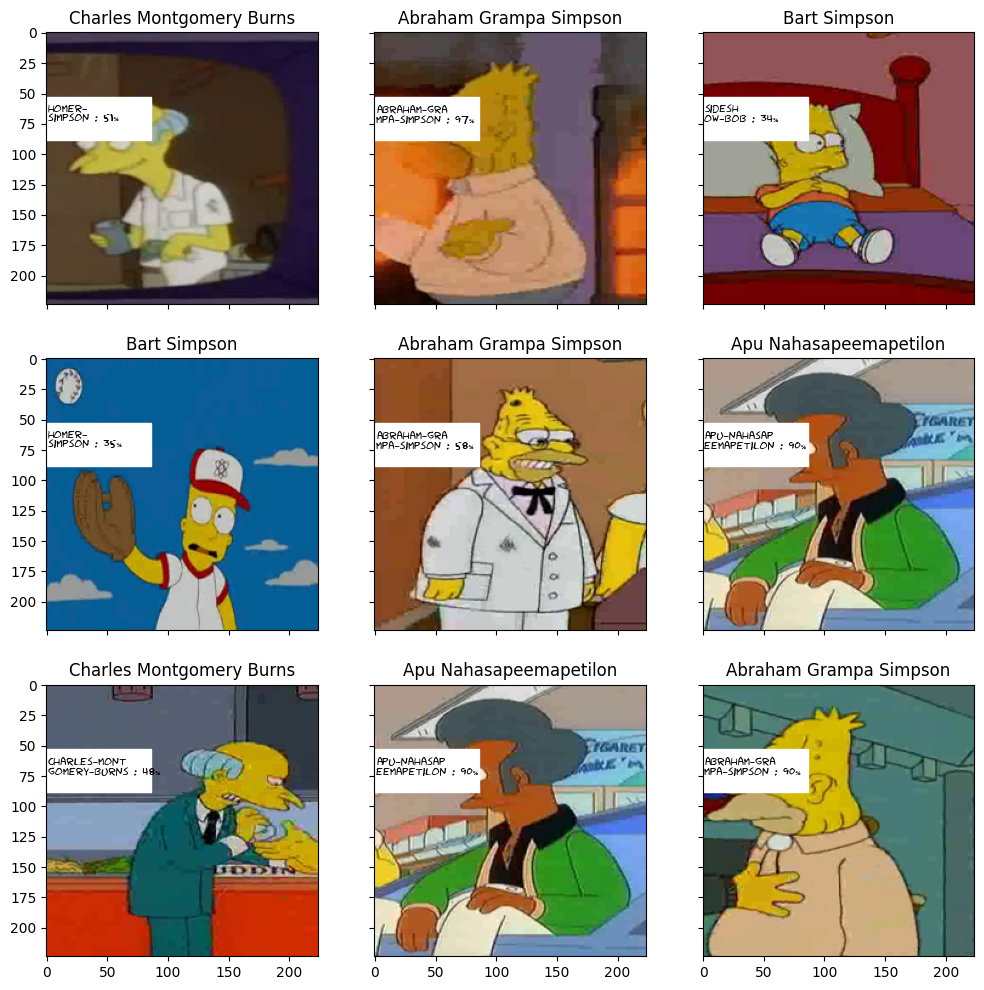

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [ ]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
#Дообучим RESNET
from torchvision.models import resnet50

In [ ]:
model = resnet50()

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Заменим fc модуль видно что на вход дает 2048 картинок


In [ ]:
class NewOutLayer(nn.Module):
    def __init__(self, input_features, output, drop_prob=0.5):
        super(NewOutLayer, self).__init__()
        self.active = nn.ReLU()


        self.linear_1 = nn.Linear(input_features, int(input_features // 2))
        self.batch_norm_1 = nn.BatchNorm1d(int(input_features // 2))
        self.drop_1 = nn.Dropout(p=drop_prob)

        self.linear_2 = nn.Linear(int(input_features // 2), int(input_features // 4))
        self.batch_norm_2 = nn.BatchNorm1d(int(input_features // 4))
        self.drop_2 = nn.Dropout(p=drop_prob)

        self.linear_3 = nn.Linear(int(input_features // 4), int(input_features // 8))
        self.batch_norm_3 = nn.BatchNorm1d(int(input_features // 8))
        self.drop_3 = nn.Dropout(p=drop_prob)

        self.last = nn.Linear(int(input_features // 8), output)

    def forward(self, x):
      #1
        x = self.active(self.drop_1(self.batch_norm_1(self.linear_1(x))))
      #2
        x = self.active(self.drop_2(self.batch_norm_2(self.linear_2(x))))
      #3
        x = self.active(self.drop_3(self.batch_norm_3(self.linear_3(x))))
      #last
        x = self.last(x)
        return x

In [ ]:
n_classes

42

In [ ]:
model.fc = NewOutLayer(model.fc.in_features, n_classes, drop_prob=0.5)

In [ ]:
#Замрозим слои
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
#проверка
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.0.conv3.weight: requires_grad=False
layer1.0.bn3.weight: requires_grad=False
layer1.0.bn3.bias: requires_grad=False
layer1.0.downsample.0.weight: requires_grad=False
layer1.0.downsample.1.weight: requires_grad=False
layer1.0.downsample.1.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer1.1.conv3.weight: requires_grad=False
layer1.1.bn3.weight: requires_grad=False
layer1.1.bn3.bias: requires_grad=False
layer1.2.conv1.wei

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=20):
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0


        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}')

        # Валидация
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Вывод точности на валидации
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')



In [ ]:
import torch
from torch.utils.data import DataLoader

# Загрузка данных
train_dataset = SimpsonsDataset(files=train_files, mode='train')
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = SimpsonsDataset(files=val_files, mode='val')
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, 20)

Epoch [1/20], Loss: 2.2875
Validation Accuracy: 37.87%
Epoch [2/20], Loss: 1.8323
Validation Accuracy: 49.18%
Epoch [3/20], Loss: 1.5582
Validation Accuracy: 59.97%
Epoch [4/20], Loss: 1.3664
Validation Accuracy: 61.79%
Epoch [5/20], Loss: 1.2367
Validation Accuracy: 59.34%
Epoch [6/20], Loss: 1.1074
Validation Accuracy: 67.81%
Epoch [7/20], Loss: 1.0168
Validation Accuracy: 68.61%
Epoch [8/20], Loss: 0.9332
Validation Accuracy: 71.07%
Epoch [9/20], Loss: 0.8276
Validation Accuracy: 68.48%
Epoch [10/20], Loss: 0.7982
Validation Accuracy: 74.42%
Epoch [11/20], Loss: 0.7291
Validation Accuracy: 68.65%
Epoch [12/20], Loss: 0.6608
Validation Accuracy: 74.30%
Epoch [13/20], Loss: 0.5897
Validation Accuracy: 72.95%
Epoch [14/20], Loss: 0.5516
Validation Accuracy: 75.49%
Epoch [15/20], Loss: 0.5223
Validation Accuracy: 74.78%
Epoch [16/20], Loss: 0.4780
Validation Accuracy: 78.16%
Epoch [17/20], Loss: 0.4397
Validation Accuracy: 74.65%
Epoch [18/20], Loss: 0.3841
Validation Accuracy: 74.51%
E

In [ ]:
import torch

# Сохранение состояния модели
torch.save(model.state_dict(), 'model_state_dict.pth')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()
my_submit.to_csv('res_cnn_baseline.csv', index=False)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, file):
        self.data = file
        self.len_ = len(file)

    def __len__(self):
        return self.len_

    def __getitem__(self, index):
        self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        img = self.transform(self._prepare_example(self.data[index]))

        return img

    def _prepare_example(self, img):
        img = Image.open(img)
        img = img.resize((224, 224))
        img = np.array(img, dtype=np.float32) / 255.0
        return img

In [ ]:
test_path = Path('/content/testset/testset')
test_file = sorted(list(test_path.rglob('*.jpg')))
test_dataset = TestDataset(test_file)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
sub = []

with torch.no_grad():
    model.eval()

    for images in test_dataloader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        for prediction in predicted:
            sub.append(prediction)
name = label_encoder.classes_[[n.cpu().numpy() for n in sub]]
submission = pd.read_csv("/content/sample_submission.csv")
submission['Expected'] = name
file = [n.name for n in test_file]
submission['Id'] = file
submission.to_csv('submission.csv', index=False)

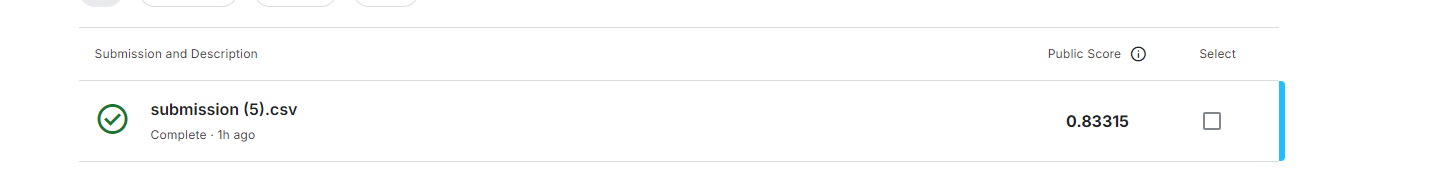

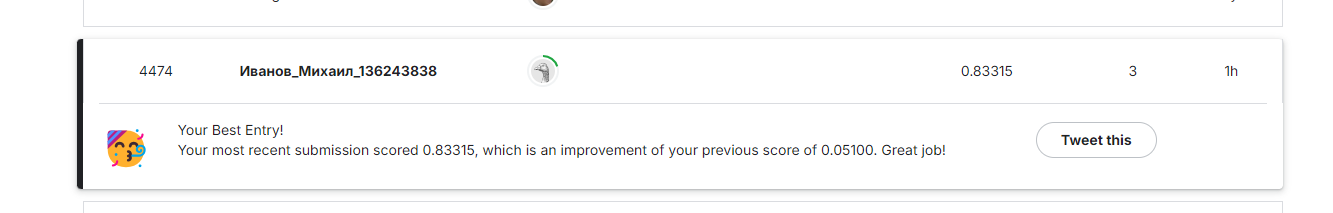

In [ ]:
#Используем модель resnet обученную но обновленном датасете IMAGENET1K_V2

In [ ]:
model = resnet50(weights="IMAGENET1K_V2")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [ ]:
model.fc = NewOutLayer(model.fc.in_features, n_classes, drop_prob=0.5)

In [ ]:
#Замрозим слои
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
import torch

def train_model(model, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs=20):
    torch.cuda.empty_cache()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0


        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()


        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_dataloader):.4f}')

        # Валидация
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Вывод точности на валидации
        print(f'Validation Accuracy: {100 * correct / total:.2f}%')



In [ ]:
import torch
from torch.utils.data import DataLoader

# Загрузка данных
train_dataset = SimpsonsDataset(files=train_files, mode='train')
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

val_dataset = SimpsonsDataset(files=val_files, mode='val')
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, device, 20)

Epoch [1/20], Loss: 1.2441
Validation Accuracy: 88.46%
Epoch [2/20], Loss: 0.3524
Validation Accuracy: 93.58%
Epoch [3/20], Loss: 0.1792
Validation Accuracy: 94.13%
Epoch [4/20], Loss: 0.1059
Validation Accuracy: 95.87%
Epoch [5/20], Loss: 0.0671
Validation Accuracy: 95.70%
Epoch [6/20], Loss: 0.0499
Validation Accuracy: 95.62%
Epoch [7/20], Loss: 0.0328
Validation Accuracy: 96.29%
Epoch [8/20], Loss: 0.0402
Validation Accuracy: 96.37%
Epoch [9/20], Loss: 0.0284
Validation Accuracy: 96.14%
Epoch [10/20], Loss: 0.0196
Validation Accuracy: 96.39%
Epoch [11/20], Loss: 0.0277
Validation Accuracy: 96.43%
Epoch [12/20], Loss: 0.0216
Validation Accuracy: 96.06%
Epoch [13/20], Loss: 0.0219
Validation Accuracy: 96.35%
Epoch [14/20], Loss: 0.0162
Validation Accuracy: 95.70%
Epoch [15/20], Loss: 0.0190
Validation Accuracy: 96.01%
Epoch [16/20], Loss: 0.0171
Validation Accuracy: 95.91%
Epoch [17/20], Loss: 0.0147
Validation Accuracy: 96.24%
Epoch [18/20], Loss: 0.0106
Validation Accuracy: 96.77%
E

In [ ]:
import torch

# Сохранение состояния модели
torch.save(model.state_dict(), 'model_state_dict_v2.pth')

In [ ]:
test_path = Path('/content/testset/testset')
test_file = sorted(list(test_path.rglob('*.jpg')))
test_dataset = TestDataset(test_file)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)
sub = []

with torch.no_grad():
    model.eval()

    for images in test_dataloader:
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        for prediction in predicted:
            sub.append(prediction)
name = label_encoder.classes_[[n.cpu().numpy() for n in sub]]
submission = pd.read_csv("/content/sample_submission.csv")
submission['Expected'] = name
file = [n.name for n in test_file]
submission['Id'] = file
submission.to_csv('submission.csv', index=False)

К сожалению данный сабмит не получилось подгрузить из-за ограничения 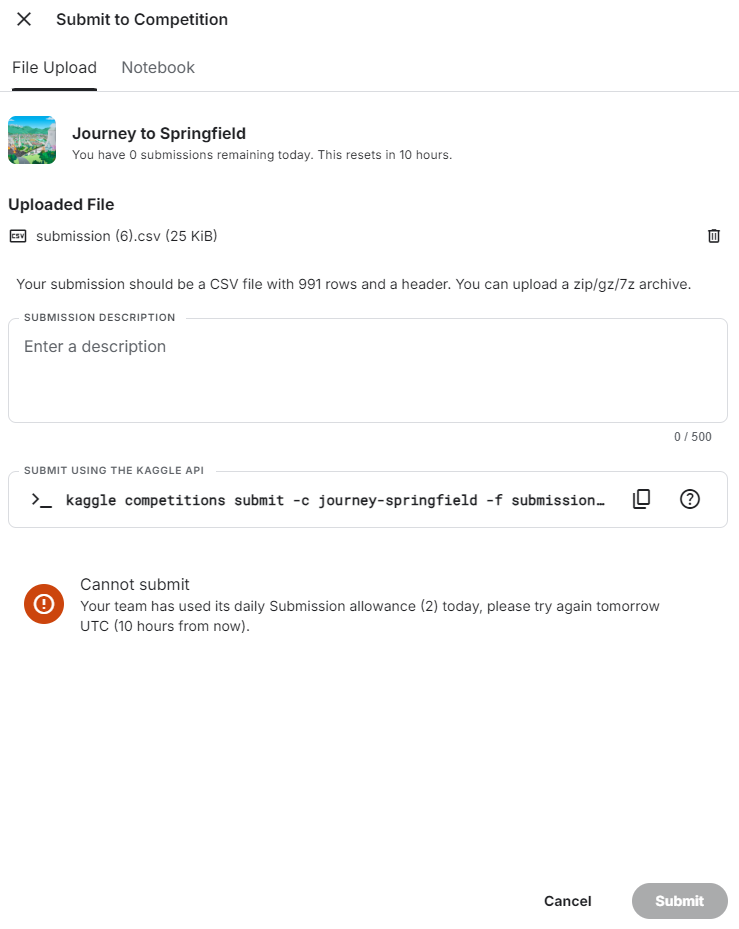

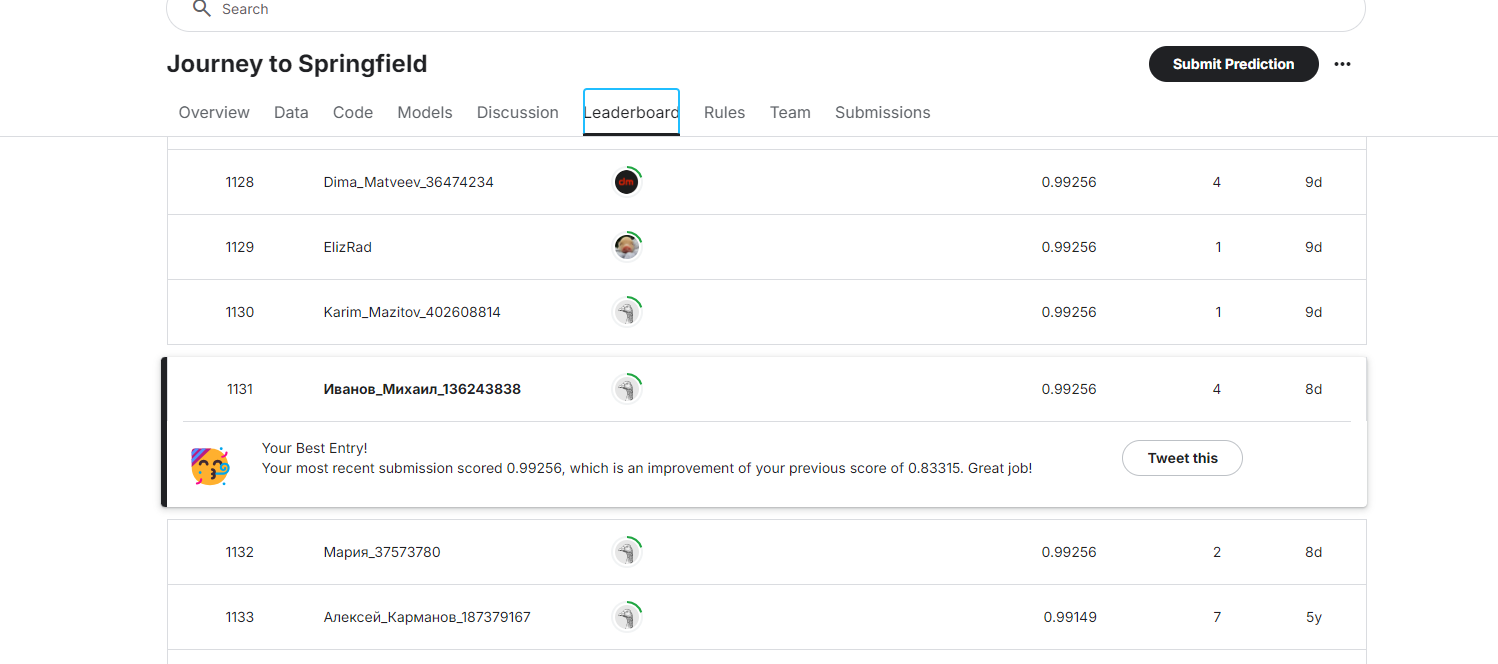

Видно что точность 0.99